In [1]:
pip install torch torchvision torchaudio

Note: you may need to restart the kernel to use updated packages.


# Deep Learning (Mini-Course)

---

### Syllabus & Learning Path (suggested 10–12 sessions)
- Origins → Perceptron → Linear vs Nonlinear → Backprop intuition
- MLPs from scratch (PyTorch Autograd), activations, loss, metrics
- Optimization (SGD→Momentum→Adam), LR schedules, initialization
- Regularization (L2, dropout, batchnorm), early stopping
- CNN intuition + minimal CNN on synthetic images, data aug basics
- ResNets (transfer/import), brief U-Net mention (vision tasks)
- Sequences: RNN, LSTM/GRU (toy character/number prediction)
- Attention from scratch: scaled dot-product, Multi-Head
- Transformer block & mini Transformer; ViT (import)
- This sets up the **LLM** notebook next (tokenization, causal masks).

**Conventions:**
- We'll generate toy datasets (2D blobs, simple images, integer sequences).
- We'll use **PyTorch** for autograd/training loops, but start with a NumPy perceptron to demystify.
- You can toggle **CPU/GPU** and run timing benchmarks.
- Every section stands alone; feel free to run in order or selectively.


In [2]:
# Core imports
import time, random
from dataclasses import dataclass
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Optional: interactive widgets (works best in Jupyter)
try:
    from ipywidgets import interact, IntSlider, FloatLogSlider, Dropdown
    HAS_WIDGETS = True
except Exception:
    HAS_WIDGETS = False


In [4]:
# Reproducibility
def set_seed(seed=42):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed(42)


In [5]:
# Device selection & simple benchmark helper
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

def benchmark_matmul(n=2000, reps=10, device=device):
    x = torch.randn(n, n, device=device)
    t0 = time.time()
    with torch.no_grad():
        for _ in range(reps):
            _ = x @ x
    dt = time.time() - t0
    print(f"Matmul {n}x{n} x{reps} on {device}: {dt:.3f}s")
    return dt


Using device: mps


---

## Part 0 — History at Warp Speed (Context, not memorization)
- 1957: **Perceptron** (Rosenblatt) → linear separator; XOR limits (Minsky & Papert, 1969).
- 1986: **Backprop** popularized (Rumelhart, Hinton, Williams). MLPs learn nonlinear boundaries.
- 1998: **LeNet-5** (LeCun) → CNNs for digits.
- 2012: **AlexNet** (Krizhevsky, Sutskever, Hinton) → GPU + ReLU + data → ImageNet breakthrough.
- 2014–16: **GANs**, **ResNets**, **BatchNorm**, **Adam**, **LSTMs/GRUs** dominate benchmarks.
- 2017: **Attention is All You Need** → **Transformers**; sequence modeling without recurrence.
- 2020+ : **ViT** for vision; foundation models & LLMs.

We'll implement tiny versions to feel the mechanics, then import advanced ones to recognize patterns.



**Reading list (foundational):**
- [Rosenblatt](https://direct.mit.edu/books/edited-volume/5003/chapter-abstract/2657041/The-Perceptron-A-Probabilistic-Model-for?redirectedFrom=fulltext), *The Perceptron: A Probabilistic Model…* (1958)
- [Rumelhart et al.](https://www.nature.com/articles/323533a0), *Learning representations by back-propagating errors* (1986)
- [LeCun et al.](https://ieeexplore.ieee.org/document/726791), *Gradient-based learning applied to document recognition* (1998)
- [Krizhevsky et al.](https://proceedings.neurips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf), *ImageNet Classification with Deep CNNs* (2012)
- [He et al.](https://arxiv.org/pdf/1512.03385), *Deep Residual Learning for Image Recognition* (2015)
- [Ioffe & Szegedy](https://arxiv.org/pdf/1502.03167), *Batch Normalization* (2015)
- [Kingma & Ba](https://arxiv.org/pdf/1412.6980), *Adam: A Method for Stochastic Optimization* (2014)
- [Vaswani et al.](https://arxiv.org/pdf/1706.03762), *Attention Is All You Need* (2017)
- [Dosovitskiy et al.](https://arxiv.org/pdf/2010.11929), *An Image is Worth 16x16 Words* (2020)

**Big idea:** With enough data, compute, and proper inductive biases (convolution, attention), deep nets learn powerful representations.


---

## Part 1 — The Perceptron (NumPy, no autograd)
We start with a binary linear classifier on a simple XOR-like dataset to expose limitations.
The perceptron updates weights when it makes mistakes: `w <- w + y*x` (for misclassified samples).
Expect failure on XOR (nonlinearly separable).


**Model.** For input $\mathbf{x}\in\mathbb{R}^d$, weights $\mathbf{w}$, bias $b$,
$$\hat{y} = \mathbb{1}\big[\mathbf{w}^\top \mathbf{x} + b \ge 0\big].$$

**Update rule** (on mistake for label $y\in\{-1,+1\}$):
$$\mathbf{w}\leftarrow \mathbf{w} + \eta\, y\, \mathbf{x},\quad b\leftarrow b + \eta\, y.$$

**Why XOR fails?** XOR’s positive and negative samples are not linearly separable in $\mathbb{R}^2$.
We need **nonlinear** features or multilayer networks.


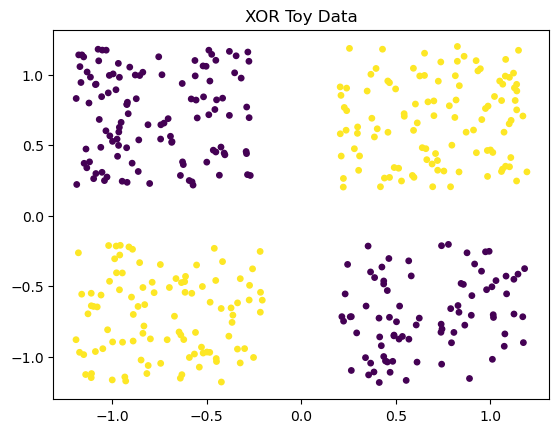

In [6]:
def make_xor(n=200, margin=0.2, seed=42):
    rng = np.random.RandomState(seed)
    X = rng.uniform(-1, 1, size=(n, 2))
    y = (X[:, 0] * X[:, 1] > 0).astype(np.int64)  # same sign -> class 1
    # push away from axes to make corners clearer
    X += margin * np.sign(X)
    return X, y

X_np, y_np = make_xor(n=400)
plt.figure(); plt.scatter(X_np[:,0], X_np[:,1], c=y_np, s=15); plt.title("XOR Toy Data"); plt.show()


In [7]:
class Perceptron:
    def __init__(self, in_dim):
        self.w = np.zeros(in_dim)
        self.b = 0.0

    def predict(self, X):
        return (X @ self.w + self.b >= 0).astype(np.int64)

    def fit(self, X, y, epochs=25, lr=0.2):
        for ep in range(epochs):
            errors = 0
            for i in range(len(X)):
                xi, yi = X[i], y[i]*2-1  # {-1, +1}
                pred = 1 if (xi @ self.w + self.b) >= 0 else -1
                if pred != yi:
                    self.w += lr * yi * xi
                    self.b += lr * yi
                    errors += 1
            if ep % 5 == 0:
                print(f"epoch {ep:02d} errors={errors}")
        return self

perc = Perceptron(2).fit(X_np, y_np, epochs=25)
acc = (perc.predict(X_np) == y_np).mean()
print("Perceptron accuracy on XOR (expect poor):", acc)


epoch 00 errors=200
epoch 05 errors=204
epoch 10 errors=215
epoch 15 errors=194
epoch 20 errors=201
Perceptron accuracy on XOR (expect poor): 0.5475


**Takeaway:** Linear separators fail on XOR. We need **nonlinear** features → MLPs with nonlinear activations.


---

## Part 2 — Minimal MLP (PyTorch Autograd)
We'll build a tiny MLP: `Linear → ReLU → Linear` on a **nonlinear** 2D dataset (spirals).
We'll track loss/accuracy and visualize the decision boundary.



**Two-layer MLP** (classification into $K$ classes):
$$
\begin{aligned}
\mathbf{h} &= \phi(W_1 \mathbf{x} + \mathbf{b}_1),\\
\mathbf{z} &= W_2 \mathbf{h} + \mathbf{b}_2,\quad
\hat{\mathbf{p}}=\mathrm{softmax}(\mathbf{z}).
\end{aligned}
$$

**Cross-entropy loss** for label $y$:
$$
\mathcal{L}=-\log \hat{p}_y,\quad
\mathrm{softmax}(\mathbf{z})_k=\frac{e^{z_k}}{\sum_j e^{z_j}}.
$$

**Backprop (chain rule)**: Autograd builds a computation graph and applies
$$
\frac{\partial \mathcal{L}}{\partial \theta}
= \frac{\partial \mathcal{L}}{\partial \mathbf{z}}\cdot
\frac{\partial \mathbf{z}}{\partial \mathbf{h}}\cdot
\frac{\partial \mathbf{h}}{\partial \theta},
$$

for each parameter $\theta\in\{W_1,\mathbf{b}_1,W_2,\mathbf{b}_2\}$.

**Nonlinearity matters:** Without $\phi$ (e.g., ReLU), stacked linear layers collapse to a single linear map.


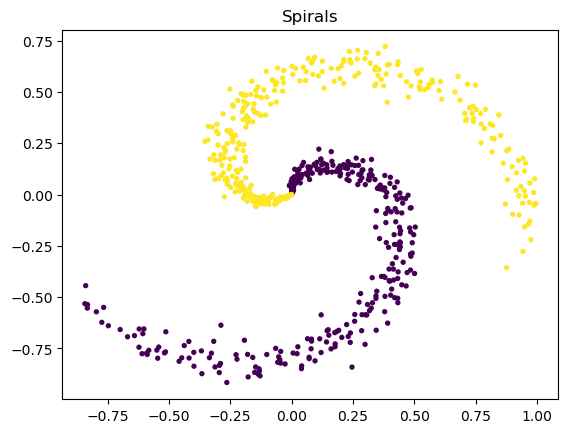

In [8]:
def make_spirals(n_per_class=200, noise=0.2, K=2, seed=42):
    rng = np.random.RandomState(seed)
    N = n_per_class * K
    X = np.zeros((N, 2), dtype=np.float32)
    y = np.zeros(N, dtype=np.int64)
    for j in range(K):
        ix = range(n_per_class*j, n_per_class*(j+1))
        r = np.linspace(0.0, 1, n_per_class)
        t = np.linspace(j*4, (j+1)*4, n_per_class) + rng.randn(n_per_class)*noise
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    return X, y

X, y = make_spirals(n_per_class=300, K=2, noise=0.2)
X_t, y_t = torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.long)

plt.figure(); plt.scatter(X[:,0], X[:,1], c=y, s=8); plt.title("Spirals"); plt.show()


In [9]:
class TinyMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=64, out_dim=2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            nn.ReLU(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x): return self.net(x)

model = TinyMLP().to(device)
opt = torch.optim.SGD(model.parameters(), lr=1.0)
criterion = nn.CrossEntropyLoss()

X_gpu, y_gpu = X_t.to(device), y_t.to(device)


In [10]:
def train_loop(model, opt, criterion, X, y, epochs=200, print_every=50):
    model.train()
    for ep in range(1, epochs+1):
        opt.zero_grad()
        logits = model(X)
        loss = criterion(logits, y)
        loss.backward()
        opt.step()
        if ep % print_every == 0:
            pred = logits.argmax(dim=1)
            acc = (pred == y).float().mean().item()
            print(f"epoch {ep:03d}  loss={loss.item():.4f}  acc={acc:.3f}")

train_loop(model, opt, criterion, X_gpu, y_gpu, epochs=300, print_every=50)


epoch 050  loss=0.2308  acc=0.900
epoch 100  loss=0.1829  acc=0.917
epoch 150  loss=0.1290  acc=0.953
epoch 200  loss=0.1048  acc=0.968
epoch 250  loss=0.0878  acc=0.978
epoch 300  loss=0.0756  acc=0.982


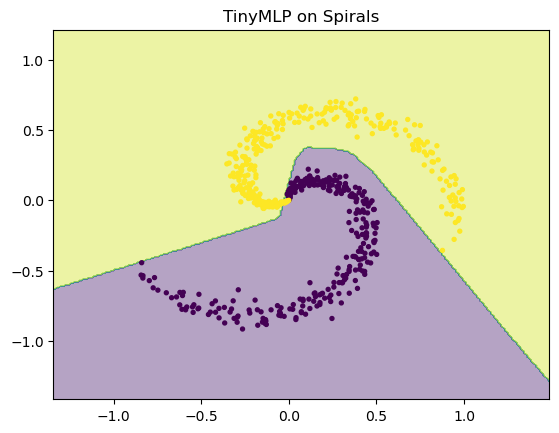

In [11]:
# Plot decision boundary
def plot_decision_boundary(model, X, y, h=0.01, title="Decision Boundary"):
    model.eval()
    xx, yy = np.meshgrid(np.arange(X[:,0].min()-0.5, X[:,0].max()+0.5, h),
                         np.arange(X[:,1].min()-0.5, X[:,1].max()+0.5, h))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32, device=device)
    with torch.no_grad():
        Z = model(grid).argmax(1).reshape(xx.shape).cpu().numpy()
    plt.figure(); plt.contourf(xx, yy, Z, alpha=0.4)
    try:
        plt.scatter(X[:,0], X[:,1], c=y.cpu().detach().numpy(), s=8); plt.title(title); plt.show()
    except:
        plt.scatter(X[:,0], X[:,1], c=y, s=8); plt.title(title); plt.show()

plot_decision_boundary(model, X, y, title="TinyMLP on Spirals")


### Backprop (intuition)
- Autograd computes gradients from the computational graph (chain rule).
- `loss.backward()` populates `param.grad`.
- `opt.step()` updates parameters.
- Nonlinear activations (ReLU, Tanh) let MLPs carve nonlinear decision boundaries.


---



## Part 3 — Activations, Losses, Metrics (quick tour)
- **Activations:** ReLU (default), Tanh/Sigmoid (careful with saturation), GELU (common in Transformers).
- **Losses:** CrossEntropy (classification), MSE (regression), BCEWithLogits (binary).
- **Metrics:** accuracy, precision/recall/F1 (sklearn or manual).
We'll quickly demonstrate swapping activations via a simple factory.



**Common activations**
- ReLU: $\mathrm{ReLU}(x)=\max(0,x)$ (fast, sparse gradients).
- GELU: $\mathrm{GELU}(x)\approx 0.5x\big(1+\tanh\!\big(\sqrt{2/\pi}(x+0.0447x^3)\big)\big)$ (used in Transformers).
- Tanh/Sigmoid: risk of saturation ([vanishing gradients](https://en.wikipedia.org/wiki/Vanishing_gradient_problem)).

**Losses (quick):**
- Multiclass CE: $\mathcal{L}=-\sum_k y_k\log \hat{p}_k$.
- Binary BCE-with-logits: $\mathcal{L}=\mathrm{softplus}(-y z)$ where $y\in\{-1,+1\}$ and $z$ is the logit.

**Metrics:** Accuracy is fine for balanced classes; use Precision/Recall/F1/AUROC as needed.


In [12]:
ACTS = {
    "relu": nn.ReLU,
    "tanh": nn.Tanh,
    "gelu": nn.GELU,
    "leakyrelu": nn.LeakyReLU,
}


In [13]:
class ConfigurableMLP(nn.Module):
    def __init__(self, in_dim=2, hidden=64, out_dim=2, act="relu"):
        super().__init__()
        A = ACTS[act]
        self.net = nn.Sequential(
            nn.Linear(in_dim, hidden),
            A(),
            nn.Linear(hidden, hidden),
            A(),
            nn.Linear(hidden, out_dim)
        )
    def forward(self, x): return self.net(x)


In [14]:
def quick_train(act="relu", lr=0.1, steps=200):
    m = ConfigurableMLP(act=act).to(device)
    opt = torch.optim.SGD(m.parameters(), lr=lr)
    for i in range(steps):
        opt.zero_grad()
        loss = F.cross_entropy(m(X_gpu), y_gpu)
        loss.backward(); opt.step()
    acc = (m(X_gpu).argmax(1)==y_gpu).float().mean().item()
    print(f"{act=} accuracy={acc:.3f}")
    plot_decision_boundary(m, X, y, title=f"Act={act}")


In [15]:
if HAS_WIDGETS:
    interact(quick_train,
             act=Dropdown(options=list(ACTS.keys()), value="relu", description="Activation"),
             lr=FloatLogSlider(base=10, min=-3, max=0, step=0.1, value=0.1, description="LR"),
             steps=IntSlider(min=50, max=500, step=50, value=200, description="Steps"))


interactive(children=(Dropdown(description='Activation', options=('relu', 'tanh', 'gelu', 'leakyrelu'), value=…

---

## Part 4 — Optimization (SGD → Momentum → Adam) & Schedules
- **SGD**: simple, may be slow; **Momentum** accelerates; **Adam** adapts per-parameter step sizes.
- LR often matters more than the optimizer choice. Try cosine or step decay.



**SGD:** $\theta_{t+1}=\theta_t-\eta\nabla_\theta \mathcal{L}_t$.

**Momentum:** with velocity $\mathbf{v}$,
$$
\mathbf{v}_{t+1}=\mu \mathbf{v}_t - \eta \nabla_\theta \mathcal{L}_t,\quad
\theta_{t+1}=\theta_t+\mathbf{v}_{t+1}.
$$

**Adam (Kingma & Ba, 2014):**
$$
\begin{aligned}
\mathbf{m}_{t}&=\beta_1 \mathbf{m}_{t-1} + (1-\beta_1)\mathbf{g}_t,\quad
\mathbf{v}_{t}=\beta_2 \mathbf{v}_{t-1} + (1-\beta_2)\mathbf{g}_t^2,\\
\hat{\mathbf{m}}_{t}&=\mathbf{m}_t/(1-\beta_1^t),\quad
\hat{\mathbf{v}}_{t}=\mathbf{v}_t/(1-\beta_2^t),\\
\theta_{t+1}&=\theta_t-\eta\frac{\hat{\mathbf{m}}_{t}}{\sqrt{\hat{\mathbf{v}}_{t}}+\epsilon}.
\end{aligned}
$$

**LR schedules:** step decay, cosine annealing; LR often dominates optimizer choice.


In [16]:
def train_with_optimizer(opt_name="sgd", lr=0.1, epochs=300):
    m = TinyMLP().to(device)
    if opt_name=="sgd":
        opt = torch.optim.SGD(m.parameters(), lr=lr)
    elif opt_name=="momentum":
        opt = torch.optim.SGD(m.parameters(), lr=lr, momentum=0.9)
    else:
        opt = torch.optim.Adam(m.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=epochs)
    for ep in range(epochs):
        opt.zero_grad()
        loss = F.cross_entropy(m(X_gpu), y_gpu)
        loss.backward(); opt.step(); scheduler.step()
    acc = (m(X_gpu).argmax(1)==y_gpu).float().mean().item()
    print(f"{opt_name=} {lr=} acc={acc:.3f}")
    return m


In [17]:
_ = train_with_optimizer("sgd", 0.5, 200)


opt_name='sgd' lr=0.5 acc=0.902


In [18]:
_ = train_with_optimizer("momentum", 0.2, 200)


opt_name='momentum' lr=0.2 acc=0.955


In [19]:
_ = train_with_optimizer("adam", 0.05, 200)


opt_name='adam' lr=0.05 acc=0.997


---

## Part 5 — Regularization: L2, Dropout, BatchNorm, Early Stopping
Regularization improves generalization. We'll show a quick pattern with a validation split.


**L2 (weight decay):** add $\lambda\|\theta\|_2^2$ to loss (or use optimizer’s `weight_decay`).

**Dropout:** during training, randomly zero units with prob $p$; scale survivors by $1/(1-p)$ so
$\mathbb{E}[\text{activation}]$ stays constant. Reduces co-adaptation.

**BatchNorm (Ioffe & Szegedy, 2015):**
$$
\hat{x}=\frac{x-\mu_B}{\sqrt{\sigma_B^2+\epsilon}},\quad
y=\gamma \hat{x}+\beta,
$$
stabilizes and accelerates training.

**Early stopping:** monitor validation loss; stop when it hasn’t improved for $k$ epochs.


In [20]:
def split_train_val(X, y, val_ratio=0.2):
    n = len(X)
    idx = np.arange(n); np.random.shuffle(idx)
    n_val = int(n*val_ratio)
    val_idx, tr_idx = idx[:n_val], idx[n_val:]
    return X[tr_idx], y[tr_idx], X[val_idx], y[val_idx]

Xtr, ytr, Xva, yva = split_train_val(X_t.numpy(), y_t.numpy(), 0.25)
Xtr, ytr = torch.tensor(Xtr, dtype=torch.float32), torch.tensor(ytr, dtype=torch.long)
Xva, yva = torch.tensor(Xva, dtype=torch.float32), torch.tensor(yva, dtype=torch.long)
Xtr, ytr, Xva, yva = Xtr.to(device), ytr.to(device), Xva.to(device), yva.to(device)


In [23]:
class RegMLP(nn.Module):
    def __init__(self, hidden=64, pdrop=0.3, use_bn=True, l2=1e-4):
        super().__init__()
        self.use_bn = use_bn
        self.l2 = l2
        self.fc1 = nn.Linear(2, hidden)
        self.bn1 = nn.BatchNorm1d(hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.bn2 = nn.BatchNorm1d(hidden)
        self.drop = nn.Dropout(pdrop)
        self.out = nn.Linear(hidden, 2)

    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x) if self.use_bn else x
        x = F.relu(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.bn2(x) if self.use_bn else x
        x = F.relu(x)
        x = self.drop(x)
        return self.out(x)


In [7]:
def train_with_early_stopping(epochs=500, patience=25, l2=1e-4):
    m = RegMLP(l2=l2).to(device)
    opt = torch.optim.Adam(m.parameters(), lr=0.05, weight_decay=l2)  # L2 via weight_decay
    best_val, best_state, wait = 1e9, None, 0
    for ep in range(1, epochs+1):
        m.train(); opt.zero_grad()
        loss = F.cross_entropy(m(Xtr), ytr)
        loss.backward(); opt.step()
        m.eval()
        with torch.no_grad():
            vloss = F.cross_entropy(m(Xva), yva).item()
        if vloss < best_val:
            best_val, best_state, wait = vloss, m.state_dict(), 0
        else:
            wait += 1
        if ep % 50 == 0:
            print(f"ep {ep:03d} train={loss.item():.3f} val={vloss:.3f} (best={best_val:.3f})")
        if wait >= patience:
            print(f"Early stop at ep {ep}, best val={best_val:.3f}")
            break
    m.load_state_dict(best_state)
    return m


In [25]:
reg_model = train_with_early_stopping()


ep 050 train=0.016 val=0.026 (best=0.024)
ep 100 train=0.012 val=0.014 (best=0.014)
Early stop at ep 129, best val=0.013


In [6]:
plot_decision_boundary(reg_model, X, y, title="Regularized MLP (Dropout+BN+L2)")


NameError: name 'plot_decision_boundary' is not defined

---

## Part 6 — CPU vs GPU (and AMP) in Practice
- Use `torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")`.
- Keep tensors and models on the **same** device.
- Mixed precision (`torch.cuda.amp.autocast`, `GradScaler`) speeds up CNN/Transformer training on newer GPUs.



- Keep tensors and model **on the same device**: CPU or CUDA.
- GPUs accelerate dense linear algebra; speedups grow with batch size and model size.
- **AMP** casts to lower precision where safe, reducing memory bandwidth:
  - Use `torch.cuda.amp.autocast` and `GradScaler`.
- Watch for numerical instabilities; keep losses well-scaled; clip gradients if needed.


In [26]:
def amp_demo(steps=2000, d=2048, device=device):
    x = torch.randn(128, d, d, device=device)
    lin = nn.Linear(d, d, device=device).to(device)
    opt = torch.optim.Adam(lin.parameters(), lr=1e-3)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
    t0 = time.time()
    for _ in range(steps):
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
            y = lin(x).mean()
        scaler.scale(y).backward()
        scaler.step(opt); scaler.update()
    print(f"AMP demo on {device}: {time.time()-t0:.2f}s")


In [27]:
# (Optional heavy) Uncomment to try small values
benchmark_matmul(1024, 5)
amp_demo(steps=200, d=512)


Matmul 1024x1024 x5 on mps: 0.059s


/var/folders/mx/l1sr7xyj2djc7mzj9s2jsym80000gp/T/ipykernel_70073/1763877398.py:5: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))
/var/folders/mx/l1sr7xyj2djc7mzj9s2jsym80000gp/T/ipykernel_70073/1763877398.py:9: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):


AMP demo on mps: 9.53s


---

## Part 7 — CNNs (from pixels to patterns)
CNNs exploit local connectivity and weight sharing. We'll create a **synthetic image** dataset
of simple shapes (squares vs circles) and train a tiny CNN.


**2D convolution** (single channel):
$$
y[i,j] = \sum_{u,v} w[u,v]\; x[i+u,\, j+v].
$$
With $C_\text{in}\to C_\text{out}$ channels:
$$
y_{c_\text{out}} = \sum_{c_\text{in}} w_{c_\text{out},c_\text{in}} * x_{c_\text{in}}.
$$

**Why CNNs?** Local connectivity + weight sharing → translation equivariance, fewer parameters.

**Pooling:** downsample (e.g., max/avg) to build spatial hierarchies and robustness.

**Parameter count:** For kernel $k\times k$, $C_\text{in}\to C_\text{out}$:
$\;\#\text{params}=k^2 C_\text{in} C_\text{out} + C_\text{out}$ (bias).

**Modern tricks:** Residual connections (ResNet), depthwise separable conv (MobileNet),
stochastic depth, label smoothing, strong augmentation (MixUp/CutMix, RandAugment).


In [28]:
def draw_square(img, size=6):
    s = img.shape[-1]
    start = np.random.randint(2, s-size-2)
    img[start:start+size, start:start+size] = 1.0

def draw_circle(img, radius=4):
    s = img.shape[-1]
    cx, cy = np.random.randint(radius+2, s-radius-2, size=2)
    ys, xs = np.ogrid[:s, :s]
    mask = (xs-cx)**2 + (ys-cy)**2 <= radius*radius
    img[mask] = 1.0

def make_shapes(n=1000, s=28):
    X = np.zeros((n, 1, s, s), dtype=np.float32)
    y = np.zeros(n, dtype=np.int64)
    for i in range(n):
        img = np.zeros((s, s), dtype=np.float32)
        if np.random.rand() < 0.5:
            draw_square(img)
            y[i] = 0
        else:
            draw_circle(img)
            y[i] = 1
        # random small translation/noise
        img += 0.05*np.random.randn(s, s)
        X[i,0] = np.clip(img, 0, 1)
    return X, y


In [31]:
Xs, ys = make_shapes(800)
Xtr, ytr, Xva, yva = split_train_val(Xs, ys, 0.25)
tr_ds = TensorDataset(torch.tensor(Xtr), torch.tensor(ytr))
va_ds = TensorDataset(torch.tensor(Xva), torch.tensor(yva))
tr_dl = DataLoader(tr_ds, batch_size=64, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=128)


In [29]:
class TinyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 8, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(8, 16, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.head = nn.Sequential(nn.Flatten(), nn.Linear(16*7*7, 32), nn.ReLU(), nn.Linear(32, 2))
    def forward(self, x): return self.head(self.conv(x))


In [32]:
def fit_cnn(epochs=8):
    m = TinyCNN().to(device)
    opt = torch.optim.Adam(m.parameters(), lr=1e-3)
    best, best_state = 0.0, None
    for ep in range(1, epochs+1):
        m.train()
        for xb, yb in tr_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = F.cross_entropy(m(xb), yb)
            loss.backward(); opt.step()
        m.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in va_dl:
                xb, yb = xb.to(device), yb.to(device)
                pred = m(xb).argmax(1)
                correct += (pred==yb).sum().item(); total += yb.numel()
        acc = correct/total
        print(f"epoch {ep} val_acc={acc:.3f}")
        if acc > best: best, best_state = acc, m.state_dict()
    m.load_state_dict(best_state)
    return m

cnn = fit_cnn(epochs=20)
print("TinyCNN ready.")


epoch 1 val_acc=0.760
epoch 2 val_acc=0.900
epoch 3 val_acc=0.765
epoch 4 val_acc=0.950
epoch 5 val_acc=0.925
epoch 6 val_acc=0.925
epoch 7 val_acc=0.925
epoch 8 val_acc=0.940
epoch 9 val_acc=0.960
epoch 10 val_acc=0.990
epoch 11 val_acc=1.000
epoch 12 val_acc=1.000
epoch 13 val_acc=1.000
epoch 14 val_acc=1.000
epoch 15 val_acc=1.000
epoch 16 val_acc=1.000
epoch 17 val_acc=1.000
epoch 18 val_acc=1.000
epoch 19 val_acc=1.000
epoch 20 val_acc=1.000
TinyCNN ready.


### Transfer to Advanced CNNs (import, don't reinvent)
In practice you'd import **ResNet**, **EfficientNet**, etc., and fine-tune. Here we show how to plug
a prebuilt model head on dummy image features. (We’ll avoid downloads; this is just API familiarity.)


**Residual block:** Learn *residual* $F(\mathbf{x})$ and set $\mathbf{y}=\mathbf{x}+F(\mathbf{x})$.
This creates **identity paths** that ease gradient flow in deep nets.

**When to import vs implement:** For production, import tested architectures (ResNet, EfficientNet, ConvNeXt).
For learning, implement tiny nets to understand compute/memory tradeoffs.


In [29]:
from torchvision.models import resnet18

In [30]:
# Create a resnet and replace the classifier head for 2 classes
res = resnet18(weights=None)  # no internet needed; random init -> or change to 'DEFAULT' for pretrained weights
res.fc = nn.Linear(res.fc.in_features, 2)
res = res.to(device)
print("ResNet18 (random init) with 2-class head is ready (dummy demo).")


ResNet18 (random init) with 2-class head is ready (dummy demo).


---

## Part 8 — Sequences: RNNs/LSTMs/GRUs (toy next-token)
We'll fit a tiny model to predict the next integer modulo `M` for synthetic sequences.
This is *not* about accuracy—it's to demonstrate the API and shapes.


**Vanilla RNN:**
$$
\mathbf{h}_t=\phi(W_{xh}\mathbf{x}_t + W_{hh}\mathbf{h}_{t-1} + \mathbf{b}_h),\quad
\hat{\mathbf{y}}_t=W_{hy}\mathbf{h}_t+\mathbf{b}_y.
$$
Suffers vanishing/exploding gradients for long sequences.

**LSTM** ([Hochreiter & Schmidhuber](https://ieeexplore.ieee.org/abstract/document/6795963), 1997) with gates:
$$
\begin{aligned}
\mathbf{i}_t&=\sigma(W_{xi}\mathbf{x}_t + W_{hi}\mathbf{h}_{t-1}+\mathbf{b}_i),\\
\mathbf{f}_t&=\sigma(W_{xf}\mathbf{x}_t + W_{hf}\mathbf{h}_{t-1}+\mathbf{b}_f),\\
\mathbf{o}_t&=\sigma(W_{xo}\mathbf{x}_t + W_{ho}\mathbf{h}_{t-1}+\mathbf{b}_o),\\
\tilde{\mathbf{c}}_t&=\tanh(W_{xc}\mathbf{x}_t+W_{hc}\mathbf{h}_{t-1}+\mathbf{b}_c),\\
\mathbf{c}_t&=\mathbf{f}_t\odot \mathbf{c}_{t-1} + \mathbf{i}_t\odot \tilde{\mathbf{c}}_t,\\
\mathbf{h}_t&=\mathbf{o}_t\odot \tanh(\mathbf{c}_t).
\end{aligned}
$$
**GRU** is a simpler gated variant (Cho et al., 2014). Here is a nice [DL tutorial](https://d2l.ai/chapter_recurrent-modern/gru.html).

**Takeaway:** Gates help preserve/forget information over longer ranges, but sequential recurrence limits parallelism.


In [31]:
def make_int_sequences(num=2000, length=10, M=8, seed=42):
    rng = np.random.RandomState(seed)
    X = rng.randint(0, M, size=(num, length))
    y = (X.sum(axis=1) % M)  # a simple function of the sequence
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long), M


In [32]:
Xs, ys, M = make_int_sequences(num=2000, length=12, M=10)
tr_ds = TensorDataset(Xs[:1600], ys[:1600])
va_ds = TensorDataset(Xs[1600:], ys[1600:])
tr_dl = DataLoader(tr_ds, batch_size=64, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=128)


In [33]:
Xs

tensor([[6, 3, 7,  ..., 4, 3, 7],
        [7, 2, 5,  ..., 0, 9, 5],
        [8, 0, 9,  ..., 2, 6, 4],
        ...,
        [9, 6, 9,  ..., 3, 8, 2],
        [4, 9, 8,  ..., 6, 0, 3],
        [9, 3, 4,  ..., 8, 5, 0]])

In [34]:
ys

tensor([4, 0, 4,  ..., 0, 3, 3])

In [35]:
M

10

In [36]:
class TinyRNN(nn.Module):
    def __init__(self, vocab=10, emb=16, hidden=32, kind="rnn"):
        super().__init__()
        self.emb = nn.Embedding(vocab, emb)
        if kind=="rnn":
            self.core = nn.RNN(emb, hidden, batch_first=True)
        elif kind=="gru":
            self.core = nn.GRU(emb, hidden, batch_first=True)
        else:
            self.core = nn.LSTM(emb, hidden, batch_first=True)
        self.fc = nn.Linear(hidden, vocab)
        self.kind = kind
    def forward(self, x):
        x = self.emb(x)
        out, _ = self.core(x)           # [B, T, H]
        h_last = out[:, -1, :]          # take last hidden state
        return self.fc(h_last)


In [37]:
def train_seq(kind="rnn", epochs=20):
    m = TinyRNN(vocab=M, kind=kind).to(device)
    opt = torch.optim.Adam(m.parameters(), lr=1e-2)
    for ep in range(1, epochs+1):
        m.train()
        for xb, yb in tr_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = F.cross_entropy(m(xb), yb)
            loss.backward(); opt.step()
        m.eval()
        with torch.no_grad():
            xb, yb = next(iter(va_dl))
            xb, yb = xb.to(device), yb.to(device)
            pred = m(xb).argmax(1)
            acc = (pred==yb).float().mean().item()
        print(f"{kind} ep {ep} val_acc={acc:.3f}")
    return m


In [38]:
_ = train_seq("rnn")


rnn ep 1 val_acc=0.117
rnn ep 2 val_acc=0.094
rnn ep 3 val_acc=0.125
rnn ep 4 val_acc=0.117
rnn ep 5 val_acc=0.094
rnn ep 6 val_acc=0.117
rnn ep 7 val_acc=0.117
rnn ep 8 val_acc=0.102
rnn ep 9 val_acc=0.102
rnn ep 10 val_acc=0.086
rnn ep 11 val_acc=0.117
rnn ep 12 val_acc=0.062
rnn ep 13 val_acc=0.117
rnn ep 14 val_acc=0.125
rnn ep 15 val_acc=0.125
rnn ep 16 val_acc=0.117
rnn ep 17 val_acc=0.086
rnn ep 18 val_acc=0.109
rnn ep 19 val_acc=0.102
rnn ep 20 val_acc=0.094


In [39]:
_ = train_seq("gru")


gru ep 1 val_acc=0.094
gru ep 2 val_acc=0.117
gru ep 3 val_acc=0.125
gru ep 4 val_acc=0.141
gru ep 5 val_acc=0.148
gru ep 6 val_acc=0.141
gru ep 7 val_acc=0.133
gru ep 8 val_acc=0.156
gru ep 9 val_acc=0.188
gru ep 10 val_acc=0.133
gru ep 11 val_acc=0.148
gru ep 12 val_acc=0.133
gru ep 13 val_acc=0.180
gru ep 14 val_acc=0.141
gru ep 15 val_acc=0.172
gru ep 16 val_acc=0.172
gru ep 17 val_acc=0.133
gru ep 18 val_acc=0.164
gru ep 19 val_acc=0.172
gru ep 20 val_acc=0.141


In [40]:
_ = train_seq("lstm")


lstm ep 1 val_acc=0.086
lstm ep 2 val_acc=0.125
lstm ep 3 val_acc=0.094
lstm ep 4 val_acc=0.133
lstm ep 5 val_acc=0.094
lstm ep 6 val_acc=0.094
lstm ep 7 val_acc=0.141
lstm ep 8 val_acc=0.070
lstm ep 9 val_acc=0.055
lstm ep 10 val_acc=0.086
lstm ep 11 val_acc=0.094
lstm ep 12 val_acc=0.086
lstm ep 13 val_acc=0.109
lstm ep 14 val_acc=0.117
lstm ep 15 val_acc=0.094
lstm ep 16 val_acc=0.102
lstm ep 17 val_acc=0.078
lstm ep 18 val_acc=0.086
lstm ep 19 val_acc=0.094
lstm ep 20 val_acc=0.094


---

## Part 9 — Attention (from scratch)
**Scaled dot-product attention:**
`Attention(Q,K,V) = softmax(QK^T / sqrt(d_k)) V`
We'll implement a tiny single-head attention, then a multi-head wrapper.


**Scaled dot-product attention** (queries $Q$, keys $K$, values $V$):
$$
\mathrm{Attn}(Q,K,V)=\mathrm{softmax}\!\left(\frac{QK^\top}{\sqrt{d_k}}\right)V.
$$
**Masks** (e.g., causal) set illegal positions to $-\infty$ before softmax.

**Multi-head attention**:
$$
\mathrm{MHA}(X)=\mathrm{Concat}(\text{head}_1,\ldots,\text{head}_h)W^O,\quad
\text{head}_i=\mathrm{Attn}(XW_i^Q, XW_i^K, XW_i^V).
$$

**Why it works:** Each head learns different relation patterns; parallelizable across sequence positions.
**Cost:** $O(T^2 d)$ time/memory (for length $T$). Many efficient variants exist (Linformer, Performer, Flash-Attention).


In [5]:
class DotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = d_k ** -0.5
    def forward(self, Q, K, V, mask=None):
        # Q: [B, T_q, d], K: [B, T_k, d], V: [B, T_k, d_v]
        scores = Q @ K.transpose(-2, -1) * self.scale  # [B, T_q, T_k]
        if mask is not None:
            scores = scores.masked_fill(mask==0, -1e9)
        attn = scores.softmax(dim=-1)
        return attn @ V, attn


In [42]:
class MultiHead(nn.Module):
    def __init__(self, d_model=64, num_heads=4):
        super().__init__()
        assert d_model % num_heads == 0
        self.h = num_heads; self.dk = d_model // num_heads
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.attn = DotProductAttention(self.dk)
    def split(self, x):
        B,T,D = x.shape
        x = x.view(B, T, self.h, self.dk).transpose(1,2)  # [B, H, T, dk]
        return x
    def combine(self, x):
        B,H,T,dk = x.shape
        x = x.transpose(1,2).contiguous().view(B, T, H*dk)
        return x
    def forward(self, x, mask=None):
        Q = self.split(self.Wq(x)); K = self.split(self.Wk(x)); V = self.split(self.Wv(x))
        # compute attention per head
        B,H,T,_ = Q.shape
        out_heads, _ = self.attn(
            Q.reshape(B*H, T, self.dk),
            K.reshape(B*H, T, self.dk),
            V.reshape(B*H, T, self.dk),
            None if mask is None else mask.repeat_interleave(H, dim=0)
        )
        out = out_heads.view(B, H, T, self.dk)
        return self.out(self.combine(out))


In [43]:
# Quick smoke test
x = torch.randn(8, 12, 64).to(device)
mh = MultiHead(d_model=64, num_heads=4).to(device)
y = mh(x)
print("MultiHead ok:", y.shape)


MultiHead ok: torch.Size([8, 12, 64])


---

## Part 10 — Transformer Block (mini)
A minimal **Transformer encoder block**: Multi-Head Attention → Add & Norm → FFN → Add & Norm.


**Layer structure (pre-norm variant):**

$$
\begin{aligned}
\mathbf{z}_1 &= \mathbf{x} + \mathrm{Dropout}(\mathrm{MHA}(\mathrm{LN}(\mathbf{x}))), & \text{(self-attention)}\\
\mathbf{z}_2 &= \mathbf{z}_1 + \mathrm{Dropout}(\mathrm{FFN}(\mathrm{LN}(\mathbf{z}_1))), & \text{(per-position MLP)}
\end{aligned}
$$
where FFN is position-wise:
$$
\mathrm{FFN}(\mathbf{u})=\sigma(\mathbf{u}W_1+\mathbf{b}_1)W_2+\mathbf{b}_2.
$$

**Positional information:** Add **positional encodings** or learnable embeddings so the model
knows order:
- Sinusoidal (Vaswani et al., 2017):
  $$
  \mathrm{PE}_{(pos,2i)}=\sin\!\left(\frac{pos}{10000^{2i/d}}\right),\quad
  \mathrm{PE}_{(pos,2i+1)}=\cos\!\left(\frac{pos}{10000^{2i/d}}\right).
  $$
- Or **learnable** positional embeddings (common in modern implementations).

**CLS token:** Prepend a learned vector; use its final hidden state for classification.


In [4]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=64, num_heads=4, d_ff=128, pdrop=0.1):
        super().__init__()
        self.mha = MultiHead(d_model, num_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(pdrop)
    def forward(self, x, mask=None):
        x = x + self.drop(self.mha(self.ln1(x), mask))
        x = x + self.drop(self.ff(self.ln2(x)))
        return x


In [3]:
# Tiny demo: sequence classification with a CLS token embedding
class TinyTransformerClassifier(nn.Module):
    def __init__(self, vocab=50, d_model=64, n_heads=4, n_layers=2, d_ff=128, max_len=32, num_classes=5):
        super().__init__()
        self.tok = nn.Embedding(vocab, d_model)
        self.pos = nn.Parameter(torch.randn(1, max_len, d_model)*0.01)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.cls = nn.Parameter(torch.randn(1, 1, d_model))
        self.head = nn.Linear(d_model, num_classes)
        self.max_len = max_len
    def forward(self, x):
        B,T = x.shape
        assert T <= self.max_len
        h = self.tok(x) + self.pos[:, :T, :]
        cls = self.cls.expand(B, -1, -1)
        h = torch.cat([cls, h], dim=1)  # [B, 1+T, D]
        for blk in self.blocks:
            h = blk(h)
        cls_h = h[:, 0, :]
        return self.head(cls_h)


In [46]:
# Synthetic token sequences
def make_token_data(n=2000, T=16, vocab=50, classes=5, seed=42):
    rng = np.random.RandomState(seed)
    X = rng.randint(0, vocab, size=(n, T))
    # label is a simple hash of tokens
    y = (X.sum(axis=1) % classes)
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)

Xt, yt = make_token_data(n=2000, T=16, vocab=60, classes=6)
train_ds = TensorDataset(Xt[:1600], yt[:1600])
val_ds = TensorDataset(Xt[1600:], yt[1600:])
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=128)


In [47]:
def train_tiny_transformer(epochs=6):
    m = TinyTransformerClassifier(vocab=60, num_classes=6).to(device)
    opt = torch.optim.AdamW(m.parameters(), lr=3e-4)
    for ep in range(1, epochs+1):
        m.train()
        for xb, yb in train_dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = F.cross_entropy(m(xb), yb)
            loss.backward(); opt.step()
        m.eval()
        with torch.no_grad():
            xb, yb = next(iter(val_dl))
            xb, yb = xb.to(device), yb.to(device)
            acc = (m(xb).argmax(1)==yb).float().mean().item()
        print(f"Transformer ep {ep} val_acc={acc:.3f}")
    return m

tt = train_tiny_transformer(epochs=20)


Transformer ep 1 val_acc=0.148
Transformer ep 2 val_acc=0.164
Transformer ep 3 val_acc=0.125
Transformer ep 4 val_acc=0.180
Transformer ep 5 val_acc=0.148
Transformer ep 6 val_acc=0.172
Transformer ep 7 val_acc=0.180
Transformer ep 8 val_acc=0.172
Transformer ep 9 val_acc=0.203
Transformer ep 10 val_acc=0.141
Transformer ep 11 val_acc=0.188
Transformer ep 12 val_acc=0.188
Transformer ep 13 val_acc=0.211
Transformer ep 14 val_acc=0.188
Transformer ep 15 val_acc=0.195
Transformer ep 16 val_acc=0.180
Transformer ep 17 val_acc=0.203
Transformer ep 18 val_acc=0.188
Transformer ep 19 val_acc=0.227
Transformer ep 20 val_acc=0.164


### Part 10.1 — Enhanced Transformer Encoder Block (with Transforms & DataLoader Options)

Below we (1) define simple **token-level transforms** for synthetic NLP-like data, (2) add a
`collate_fn` that **pads to the max length in the batch** and builds an **attention mask**, and
(3) instantiate **DataLoaders** demonstrating useful options.

**Why transforms for text?** Even on toy integer tokens, transforms help you teach the *data
pipeline* concept: masking, random deletion, light noise. In real NLP, you’d do subword
tokenization (BPE/WordPiece) and possibly whole-word masking or span corruption.

**DataLoader options (quick guide):**
- `batch_size`: samples per step. Larger is faster (if memory allows).
- `shuffle`: reshuffle every epoch to reduce ordering bias (typically `True` for training).
- `num_workers`: subprocesses for background loading; start with `2–8` (0 on Windows/limited envs).
- `pin_memory`: if using CUDA, set `True` to speed host→GPU transfers.
- `persistent_workers`: keep workers alive across epochs (speeds up long runs).
- `prefetch_factor`: how many batches each worker preloads (`>=2` when `num_workers>0`).
- `drop_last`: drop last partial batch (useful for even batch sizes on multi-GPU).
- `collate_fn`: custom batching (padding, masks). Essential for variable-length sequences.

We use **learnable positional embeddings**, a **pre-norm** Transformer block, and a `[CLS]` token
for sequence classification. The collate builds an `attn_mask` so attention can ignore padding.


### Learnable Positional Embeddings (instead of sinusoidal)

Transformers need position information because self-attention alone is permutation-invariant.  
Instead of fixed sinusoidal encodings (Vaswani et al., 2017), many models use **learnable positional embeddings**.

**1. Absolute Learnable Embeddings (BERT, ViT)**
- Each position `p` has its own vector `P[p]` learned like a token embedding.
- Added directly to token embeddings:  
  $$
  h_0 = E(x) + P[p]
  $$
- Limitation: maximum sequence length is fixed at training time (e.g., 512 for BERT).

**2. Relative Positional Embeddings (Transformer-XL, T5, DeBERTa)**
- Attention score between tokens i and j depends on relative distance (i - j).
- Example modification:  
  $$
  \text{score}_{ij} = \frac{Q_iK_j^\top}{\sqrt{d}} + a(i-j)
  $$
- Generalizes better to unseen lengths.

**3. Rotary Position Embeddings (RoPE, used in LLaMA, GPT-NeoX)**
- Instead of adding vectors, apply a rotation matrix to queries and keys.  
- Preserves relative distances directly in dot-products.  
- Efficient and extrapolates to longer sequences.

**4. ALiBi (Attention with Linear Biases, 2021)**
- No embedding vectors; just biases attention scores linearly by distance.  
- Used in OPT and MPT; scales to arbitrarily long contexts.

**5. Other domains:**
- **CLIP (Radford et al., 2021)**: Vision Transformer backbone uses **learnable absolute positional embeddings** for image patches ([paper](https://arxiv.org/abs/2103.00020)).
- **Video Transformers**: Often combine **spatial** + **temporal** embeddings.  
  - Each patch has a 2D position embedding + a separate learned embedding for frame index.  
  - Example: TimeSformer ([paper](https://arxiv.org/abs/2102.05095)) adds temporal embeddings to patch embeddings.


**PyTorch Example: Learnable Absolute Positional Embedding**
```python
class LearnablePositionalEncoding(nn.Module):
    def __init__(self, max_len=512, d_model=768):
        super().__init__()
        self.pos_emb = nn.Embedding(max_len, d_model)
    def forward(self, x):
        B, T, D = x.shape
        positions = torch.arange(T, device=x.device).unsqueeze(0).expand(B, T)
        return x + self.pos_emb(positions)
```



**See also:**
- [BERT (absolute embeddings)](https://arxiv.org/abs/1810.04805)  
- [Transformer-XL (relative)](https://arxiv.org/abs/1901.02860)  
- [T5 (relative bias)](https://arxiv.org/abs/1910.10683)  
- [DeBERTa (disentangled relative)](https://arxiv.org/abs/2006.03654)  
- [RoPE (rotary embeddings)](https://arxiv.org/abs/2104.09864)  
- [ALiBi (linear biases)](https://arxiv.org/abs/2108.12409)  
- [CLIP (vision+text)](https://arxiv.org/abs/2103.00020)  
- [TimeSformer (video)](https://arxiv.org/abs/2102.05095)


In [48]:
import math, random, numpy as np, torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")


In [49]:
# ---------- Synthetic token dataset (same spirit as before) ----------
def make_token_data(n=2000, T=16, vocab=50, classes=5, seed=42):
    rng = np.random.RandomState(seed)
    X = rng.randint(0, vocab, size=(n, T))
    y = (X.sum(axis=1) % classes)
    return torch.tensor(X, dtype=torch.long), torch.tensor(y, dtype=torch.long)


In [50]:
# ---------- Simple token-level transforms ----------
class RandomTokenMask:
    """Randomly replace tokens with a special [MASK] id (defaults to vocab-1)."""
    def __init__(self, vocab_size, mask_prob=0.1, mask_id=None):
        self.vocab_size = vocab_size
        self.mask_prob = mask_prob
        self.mask_id = mask_id if mask_id is not None else vocab_size - 1
    def __call__(self, seq: torch.Tensor):
        if self.mask_prob <= 0: return seq
        seq = seq.clone()
        mask = torch.rand_like(seq.float()) < self.mask_prob
        seq[mask] = self.mask_id
        return seq

class RandomTokenDrop:
    """Delete each token with probability p; keep at least 1 token."""
    def __init__(self, drop_prob=0.1):
        self.drop_prob = drop_prob
    def __call__(self, seq: torch.Tensor):
        if self.drop_prob <= 0: return seq
        keep = torch.rand_like(seq.float()) >= self.drop_prob
        if keep.sum() == 0:
            keep[random.randrange(len(seq))] = True
        return seq[keep]

class RandomTokenNoise:
    """Randomly replace some tokens with a random token."""
    def __init__(self, vocab_size, noise_prob=0.05):
        self.vocab_size = vocab_size
        self.noise_prob = noise_prob
    def __call__(self, seq: torch.Tensor):
        if self.noise_prob <= 0: return seq
        seq = seq.clone()
        sel = torch.rand_like(seq.float()) < self.noise_prob
        seq[sel] = torch.randint(low=0, high=self.vocab_size, size=(sel.sum().item(),))
        return seq

class Compose:
    def __init__(self, transforms):
        self.transforms = transforms
    def __call__(self, seq: torch.Tensor):
        for t in self.transforms:
            seq = t(seq)
        return seq

In [51]:
# ---------- Dataset wrapper with optional transform ----------
class TokenDataset(Dataset):
    def __init__(self, X: torch.Tensor, y: torch.Tensor, transform=None):
        self.X, self.y, self.transform = X, y, transform
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        seq = self.X[idx]
        if self.transform is not None:
            seq = self.transform(seq)
        return seq, self.y[idx]


In [52]:
# ---------- Collate function: pad & build attention mask ----------
def pad_collate_fn(batch, pad_id=0, add_cls=True, cls_id=None, max_len=None):
    """
    batch: list of (seq, label) with potentially different seq lengths (after transforms).
    - Pads sequences to max length in batch (or `max_len` if provided).
    - Optionally prepends a [CLS] token (cls_id). If cls_id is None, reuse pad_id (value
      doesn't matter since it's embedded and learned).
    Returns:
      tokens: LongTensor [B, T]
      attn_mask: BoolTensor [B, T] (True for real tokens, False for padding)
      labels: LongTensor [B]
    """
    seqs, labels = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.long)

    # Convert to list of 1D tensors (already LongTensor)
    seqs = [s if s.ndim == 1 else s.view(-1) for s in seqs]

    if add_cls:
        cid = pad_id if cls_id is None else cls_id
        seqs = [torch.cat([torch.tensor([cid], dtype=torch.long), s]) for s in seqs]

    T = max_len if max_len is not None else max(len(s) for s in seqs)
    out = torch.full((len(seqs), T), fill_value=pad_id, dtype=torch.long)
    mask = torch.zeros((len(seqs), T), dtype=torch.bool)
    for i, s in enumerate(seqs):
        t = min(T, len(s))
        out[i, :t] = s[:t]
        mask[i, :t] = True
    return out, mask, labels


In [53]:
# ---------- Transformer components ----------
class DotProductAttention(nn.Module):
    def __init__(self, d_k):
        super().__init__()
        self.scale = d_k ** -0.5
    def forward(self, Q, K, V, mask=None):
        # Q,K,V: [B, T, d]
        scores = Q @ K.transpose(-2, -1) * self.scale  # [B, T, T]
        if mask is not None:
            # mask: [B, T] -> [B, 1, T] for broadcasting across query length
            scores = scores.masked_fill(~mask.unsqueeze(1), float('-inf'))
        attn = scores.softmax(dim=-1)
        return attn @ V, attn


In [54]:
class MultiHead(nn.Module):
    def __init__(self, d_model=64, num_heads=4):
        super().__init__()
        assert d_model % num_heads == 0
        self.h = num_heads; self.dk = d_model // num_heads
        self.Wq = nn.Linear(d_model, d_model)
        self.Wk = nn.Linear(d_model, d_model)
        self.Wv = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.attn = DotProductAttention(self.dk)
    def _split(self, x):
        B, T, D = x.shape
        x = x.view(B, T, self.h, self.dk).transpose(1, 2)  # [B, H, T, dk]
        return x
    def _combine(self, x):
        B, H, T, dk = x.shape
        return x.transpose(1, 2).contiguous().view(B, T, H * dk)
    def forward(self, x, mask=None):
        Q = self._split(self.Wq(x)); K = self._split(self.Wk(x)); V = self._split(self.Wv(x))
        B, H, T, _ = Q.shape
        # Repeat mask across heads
        if mask is not None:
            mask_rep = mask.unsqueeze(1).repeat(1, H, 1)  # [B, H, T]
            mask_rep = mask_rep.reshape(B * H, T)
        else:
            mask_rep = None
        out_heads, _ = self.attn(
            Q.reshape(B * H, T, self.dk),
            K.reshape(B * H, T, self.dk),
            V.reshape(B * H, T, self.dk),
            mask_rep
        )
        out = out_heads.view(B, H, T, self.dk)
        return self.out(self._combine(out))


In [55]:
class TransformerBlock(nn.Module):
    def __init__(self, d_model=64, num_heads=4, d_ff=128, pdrop=0.1):
        super().__init__()
        self.mha = MultiHead(d_model, num_heads)
        self.ln1 = nn.LayerNorm(d_model)
        self.ff = nn.Sequential(nn.Linear(d_model, d_ff), nn.GELU(), nn.Linear(d_ff, d_model))
        self.ln2 = nn.LayerNorm(d_model)
        self.drop = nn.Dropout(pdrop)
    def forward(self, x, attn_mask=None):
        x = x + self.drop(self.mha(self.ln1(x), attn_mask))
        x = x + self.drop(self.ff(self.ln2(x)))
        return x

class TinyTransformerClassifier(nn.Module):
    def __init__(self, vocab=60, d_model=64, n_heads=4, n_layers=2, d_ff=128, max_len=64, num_classes=6, pad_id=0):
        super().__init__()
        self.tok = nn.Embedding(vocab, d_model, padding_idx=pad_id)
        self.pos = nn.Parameter(torch.randn(1, max_len, d_model) * 0.01)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, n_heads, d_ff) for _ in range(n_layers)])
        self.head = nn.Linear(d_model, num_classes)
        self.max_len = max_len
    def forward(self, tokens, attn_mask):
        B, T = tokens.shape
        assert T <= self.max_len
        h = self.tok(tokens) + self.pos[:, :T, :]
        for blk in self.blocks:
            h = blk(h, attn_mask)
        cls_h = h[:, 0, :]  # use the prepended [CLS] position (index 0)
        return self.head(cls_h)


In [56]:
# ---------- Build datasets, transforms, loaders ----------
Xt, yt = make_token_data(n=2000, T=16, vocab=60, classes=6)
print(Xt)
yt

tensor([[38, 51, 28,  ..., 23, 52, 35],
        [39, 23,  2,  ..., 32, 11, 57],
        [21, 43, 24,  ..., 43, 54, 51],
        ...,
        [42, 12, 46,  ..., 40, 57,  4],
        [ 6, 21, 58,  ..., 45, 40, 55],
        [43, 49, 40,  ..., 32, 12, 24]])


tensor([3, 0, 2,  ..., 5, 5, 2])

In [57]:
# Train-time transforms: mask + small noise + occasional drop
train_tfms = Compose([
    RandomTokenMask(vocab_size=60, mask_prob=0.10, mask_id=59),
    RandomTokenNoise(vocab_size=60, noise_prob=0.05),
    RandomTokenDrop(drop_prob=0.05),
])
val_tfms = None  # usually no augmentation on validation

train_ds = TokenDataset(Xt[:1600], yt[:1600], transform=train_tfms)
val_ds   = TokenDataset(Xt[1600:], yt[1600:], transform=val_tfms)


In [58]:
# DataLoader options demo
loader_kws = dict(
    batch_size=64,
    num_workers=0,          # try >0 for speed (set 0 if issues on your OS)
    pin_memory=(device.type == "cuda"),
    persistent_workers=None,
    prefetch_factor=None
)

train_dl = DataLoader(train_ds, shuffle=True,  drop_last=False, collate_fn=pad_collate_fn, **loader_kws)
val_dl   = DataLoader(val_ds,   shuffle=False, drop_last=False, collate_fn=pad_collate_fn, **loader_kws)


In [59]:
# ---------- Minimal training loop ----------
def train_tiny_transformer_with_transforms(epochs=4, pad_id=0):
    model = TinyTransformerClassifier(vocab=60, num_classes=6, pad_id=pad_id).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=3e-4)
    scaler = torch.cuda.amp.GradScaler(enabled=(device.type=="cuda"))

    for ep in range(1, epochs+1):
        model.train()
        for tokens, attn_mask, labels in train_dl:
            tokens, attn_mask, labels = tokens.to(device), attn_mask.to(device), labels.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=(device.type=="cuda")):
                logits = model(tokens, attn_mask)
                loss = F.cross_entropy(logits, labels)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()

        # quick val
        model.eval()
        with torch.no_grad():
            tokens, attn_mask, labels = next(iter(val_dl))
            tokens, attn_mask, labels = tokens.to(device), attn_mask.to(device), labels.to(device)
            preds = model(tokens, attn_mask).argmax(1)
            acc = (preds == labels).float().mean().item()
        print(f"epoch {ep}  val_acc={acc:.3f}")
    return model


In [60]:
_ = train_tiny_transformer_with_transforms(epochs=20)


epoch 1  val_acc=0.125
epoch 2  val_acc=0.109
epoch 3  val_acc=0.094
epoch 4  val_acc=0.109
epoch 5  val_acc=0.094
epoch 6  val_acc=0.141
epoch 7  val_acc=0.125
epoch 8  val_acc=0.109
epoch 9  val_acc=0.188
epoch 10  val_acc=0.156
epoch 11  val_acc=0.172
epoch 12  val_acc=0.172
epoch 13  val_acc=0.203
epoch 14  val_acc=0.203
epoch 15  val_acc=0.203
epoch 16  val_acc=0.203
epoch 17  val_acc=0.203
epoch 18  val_acc=0.219
epoch 19  val_acc=0.203
epoch 20  val_acc=0.156


---

## Part 11 — Vision Transformers (ViT) via Imports
For modern vision tasks, you’d typically import ViT or Swin from libraries and fine-tune.
We’ll instantiate a ViT-like model without weights to show the API.


**Patch embedding:** Split image into $P\times P$ patches, flatten, project:
$$
\mathbf{z}_0 = [\mathbf{x}_\text{cls}; \mathbf{x}_1 E; \ldots; \mathbf{x}_N E] + \mathbf{p},
$$
where $E$ projects patches to $d$-dim space; $\mathbf{p}$ are positional embeddings.

**Stack Transformer blocks**, use the CLS head for classification. Works best with large data or
strong augmentation/regularization.

**Key reference:** Dosovitskiy et al., *An Image is Worth 16x16 Words* (2020).


In [61]:
try:
    from torchvision.models import vit_b_16
    vit = vit_b_16(weights=None)  # random init, no download
    vit.heads.head = nn.Linear(vit.heads.head.in_features, 10)  # e.g., 10 classes
    vit = vit.to(device)
    print("ViT-B/16 ready (random init). In practice: load pretrained weights & fine-tune.")
except Exception as e:
    print("ViT not available in this torchvision build:", e)


ViT-B/16 ready (random init). In practice: load pretrained weights & fine-tune.


---

## Part 12 — Save/Load, Checkpoints, and Training Patterns
- Save model: `torch.save(model.state_dict(), "model.pt")`
- Load model: `model.load_state_dict(torch.load("model.pt", map_location=device))`
- Keep lightweight checkpoints (state_dict + key training state).


- Save weights: `torch.save(model.state_dict(), "model.pt")`.
- Load with `map_location=device` to restore on CPU/GPU as needed.
- Track random seeds (Python, NumPy, PyTorch), versions, and hyperparameters for reproducible runs.

**Tip:** Save the **smallest** objects you need (state_dicts, not whole objects) to avoid pickling issues.


In [62]:
def save_checkpoint(model, path="checkpoint.pt"):
    torch.save({"model": model.state_dict()}, path)
    print("Saved ->", path)

def load_checkpoint(model, path="checkpoint.pt"):
    ckpt = torch.load(path, map_location=device)
    model.load_state_dict(ckpt["model"]); print("Loaded <-", path)
    return model


In [63]:
# Example:
save_checkpoint(model, "mlp_checkpoint.pt")
_ = load_checkpoint(TinyMLP().to(device), "mlp_checkpoint.pt")


Saved -> mlp_checkpoint.pt
Loaded <- mlp_checkpoint.pt


---

## Part 13 — Training Utilities (Reusable Template)
Use this skeleton for almost any supervised task in this course.


**Training loop shape:**
1. Make `DataLoader`s.
2. Move model/data to device.
3. For each epoch:
   - Forward → loss → backward → optimizer step.
   - Optional: AMP (`autocast`, `GradScaler`).
   - Log every *k* steps.
   - Validate; track best model; early stop if desired.

**Initialization tips:** Xavier/Glorot for tanh, He/Kaiming for ReLU. Most PyTorch layers already choose reasonable defaults.


In [64]:
@dataclass
class TrainConfig:
    epochs: int = 10
    lr: float = 1e-3
    batch_size: int = 64
    weight_decay: float = 0.0
    amp: bool = (device.type=="cuda")
    log_every: int = 100


In [65]:
def generic_train(model, train_ds, val_ds=None, cfg: TrainConfig = TrainConfig()):
    dl = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True)
    vdl = DataLoader(val_ds, batch_size=cfg.batch_size) if val_ds is not None else None
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    scaler = torch.cuda.amp.GradScaler(enabled=cfg.amp)
    model = model.to(device)
    step = 0
    for ep in range(1, cfg.epochs+1):
        model.train()
        for xb, yb in dl:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad(set_to_none=True)
            with torch.cuda.amp.autocast(enabled=cfg.amp):
                loss = F.cross_entropy(model(xb), yb)
            scaler.scale(loss).backward()
            scaler.step(opt); scaler.update()
            step += 1
            if step % cfg.log_every == 0:
                print(f"ep {ep} step {step} loss {loss.item():.4f}")
        if vdl:
            model.eval()
            correct, total = 0, 0
            with torch.no_grad():
                for xb, yb in vdl:
                    xb, yb = xb.to(device), yb.to(device)
                    pred = model(xb).argmax(1)
                    correct += (pred==yb).sum().item(); total += yb.numel()
            print(f"ep {ep} val_acc={correct/total:.3f}")
    return model


In [66]:
# Quick demo with the shapes dataset & TinyCNN:
cnn2 = TinyCNN()
cnn2 = generic_train(cnn2, TensorDataset(torch.tensor(Xtr), torch.tensor(ytr)),
                     TensorDataset(torch.tensor(Xva), torch.tensor(yva)),
                     TrainConfig(epochs=20, lr=1e-3, batch_size=64))


ep 1 val_acc=0.815
ep 2 val_acc=0.880
ep 3 val_acc=0.940
ep 4 val_acc=0.975
ep 5 val_acc=0.930
ep 6 val_acc=0.965
ep 7 val_acc=0.980
ep 8 val_acc=0.990
ep 9 val_acc=0.980
ep 10 step 100 loss 0.0264
ep 10 val_acc=0.995
ep 11 val_acc=1.000
ep 12 val_acc=1.000
ep 13 val_acc=1.000
ep 14 val_acc=1.000
ep 15 val_acc=1.000
ep 16 val_acc=1.000
ep 17 val_acc=1.000
ep 18 val_acc=1.000
ep 19 val_acc=1.000
ep 20 step 200 loss 0.0043
ep 20 val_acc=1.000


## Part 14 — Exercises & What to Look For

1. **Perceptron with features:** Map $(x_1,x_2)\mapsto (x_1,x_2,x_1x_2,x_1^2,x_2^2)$; show XOR becomes separable.
2. **Activation study:** Train MLPs with ReLU/Tanh/GELU; compare decision boundaries & training curves.
3. **Optimizer sweep:** Grid over LR and optimizer (SGD/Momentum/Adam); visualize accuracy surfaces.
4. **Regularization:** Overfit a tiny set; add dropout/L2/BN; plot train vs val loss.
5. **CNN augs:** Add random shifts/rotations to shapes; measure robustness.
6. **Sequence rules:** Change target label to a function of last 3 tokens; compare RNN/GRU/LSTM.
7. **Attention maps:** Visualize $\mathrm{softmax}(QK^\top/\sqrt{d_k})$ as a heatmap for a toy sequence.
8. **Transformer scaling:** Vary heads/layers; profile time/memory CPU vs GPU; try AMP.


**Handy citations for lecture slides:**
- MLP/Backprop: Rumelhart et al. (1986)
- CNNs: LeCun et al. (1998); Krizhevsky et al. (2012)
- Optim: Kingma & Ba (2014); Ioffe & Szegedy (2015)
- ResNets: He et al. (2015)
- Attention/Transformers: Vaswani et al. (2017), arXiv:1706.03762
- ViT: Dosovitskiy et al. (2020)

---
## Where we go next (LLMs)
You now have: embeddings, attention, Transformer blocks, and training patterns.
The next notebook (LLMs) will cover **tokenization, positional encodings, causal masks, next-token training**, and
evaluation on tiny text corpora. We'll also show how to **load a small prebuilt causal model**, generate text, and
add features like **temperature, top-k/p sampling**.


---